# The Salary-Performance Relationship in the English Premier League


Last week we looked at the salary-performance relationship in the NBA. The rules governing the operation of the English Premier League are very different. Unlike the NBA, there is no salary cap, nor is there a draft system, roster limits, and the revenue sharing mechanisms used in the NBA and other North American major leagues are much more limited. 

Another important difference, which is not unconnnected, is the system of promotion and relegation. This requires that the worst performing teams in the league (measured by league position) are automatically relegated the following season to play in the next tier down, to be replaced by the best performing teams from that lower tier. This system is the norm in the world of soccer, and is perhaps the main reason that teams do not agree to restraints such as salary caps. There is a high degree of revenue inequality in soccer, and richer clubs are unwilling to share with the poorer ones, for fear that this might cause them to be relegated.

This week we are going to follow the same procedure as we did for the NBA. We will look at the impact of salaries (relative to the average for the season) on team performance (measured this time by league position), and then see how the addition of potential omitted variables - (the lagged depedent variable and fixed effects) impact the estimates.



In [1]:
# As usual, we begin by loading the packages we will need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# Now we load the data

EPL=pd.read_excel("../Data/EPL pay and performance.xlsx")

We use .describe() to look at the summary statistics for the data. From this we can see that we have 380 observations, for teams running from 1997 to 2015 (19 seasons). Our two main variables of interest are win percentage and team salaries. We also include a dummy variable for whether the team had been promoted that season. We can also use .info() to summarize the dataframe.

In [3]:
EPL.describe()

,Season_ending,promoted_last_season,Position,Revenues,salaries
count,380.000000,380.000000,380.000000,3.750000e+02,3.750000e+02
mean,2006.000000,0.150000,10.500000,8.431025e+07,5.183637e+07
std,5.484447,0.357542,5.773884,7.533617e+07,4.331005e+07
min,1997.000000,0.000000,1.000000,9.238238e+06,4.172024e+06
25%,2001.000000,0.000000,5.750000,3.895834e+07,2.413900e+07
50%,2006.000000,0.000000,10.500000,5.907200e+07,3.774400e+07
75%,2011.000000,0.000000,15.250000,9.753050e+07,6.300007e+07
max,2015.000000,1.000000,20.000000,4.331640e+08,2.331060e+08


In [4]:
EPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Season_ending         380 non-null    int64  
 1   Club                  380 non-null    object 
 2   promoted_last_season  380 non-null    int64  
 3   Position              380 non-null    int64  
 4   Revenues              375 non-null    float64
 5   salaries              375 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 17.9+ KB


We use .groupby to sum salaries. Note the way we use .reset_index and .rename(columns ={}) to make the data manageable.

In [5]:
Sumsal = EPL.groupby(['Season_ending'])['salaries'].sum().reset_index().rename(columns={'salaries':'allsal'})
Sumsal

,Season_ending,allsal
0,1997,2.195995e+08
1,1998,2.896696e+08
2,1999,3.900185e+08
3,2000,4.673185e+08
4,2001,5.622860e+08
5,2002,6.765034e+08
6,2003,7.477382e+08
7,2004,7.980298e+08
8,2005,7.836889e+08
9,2006,8.671860e+08


For numbers that have many digits, Python will typically use scientific notation to represent them. If you would rather see the data in standard decimal format you can use "pd.options.display.float_format = ". In the line below we show the salary data with no decimal places- '{:.0f}' - if you wanted the data to one decimal place you would write '{:.1f}' - this way you can format the data to as many decimal places as you prefer. Another option, if you would prefer to see the numbers in a format that is easier to read from the screen-in this case would be to divide allsal by 1,000,000.

In [6]:
pd.options.display.float_format = '{:.0f}'.format
Sumsal

,Season_ending,allsal
0,1997,219599462
1,1998,289669601
2,1999,390018517
3,2000,467318483
4,2001,562286010
5,2002,676503369
6,2003,747738215
7,2004,798029773
8,2005,783688898
9,2006,867186039


As with the NBA, the sharp upward trend in total salaries is clearly visible. allsal increased from £220 million in 1997 to £2031 million in 2015. In each season we want to compare team spending relative to the average of that season. 

To do this we now merge the aggregate salaries back in to the main dataframe and then divide the team's salary bill in each year by allsal in that year.

In [7]:
EPL = pd.merge(EPL, Sumsal, on=['Season_ending'], how='left')
display(EPL)

,Season_ending,Club,promoted_last_season,Position,Revenues,salaries,allsal
0,1997,Arsenal,0,3,27158007,15279000,219599462
1,1997,Aston Villa,0,5,22079000,10070000,219599462
2,1997,Blackburn Rovers,0,13,14302220,14336629,219599462
3,1997,Chelsea,0,6,23729000,14873000,219599462
4,1997,Coventry City,0,17,12264825,8396261,219599462
...,...,...,...,...,...,...,...
375,2015,Sunderland,0,16,101087000,77106000,2031348184
376,2015,Swansea City,0,8,103928360,82540562,2031348184
377,2015,Tottenham Hotspur,0,5,196377000,100832000,2031348184
378,2015,West Bromwich Albion,0,13,96269000,69801000,2031348184


In [8]:
# Here we create the variable 'relsal' for the EPL 

EPL['relsal']= EPL['salaries']/EPL['allsal']

Before running a regression, we use sns.reglot() to look at the relationship between salaries and win percentage on a chart.

<AxesSubplot:xlabel='relsal', ylabel='Position'>

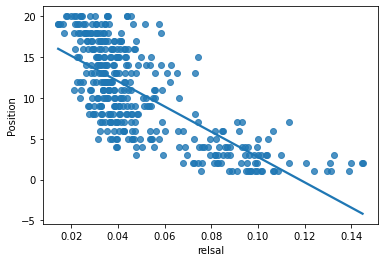

In [9]:
sns.regplot(x="relsal", y="Position", data = EPL, ci=False)

The chart shows that there is a negative relationship between league position and relsal. This is because a lower numerical value of league position means a better performance (e.g. 9 is better than 10 and 1 is better than 2). Higher wage spending relative to other teams generates a higher league position. To avoid confusion, we can reverse the relationship, so that higher spending (on the x axis) leads to a higher position on the y axis. We do this simply by defining 'mpos" as 'position' multiplied by -1. This changes nothing about the underlying logic of the relationship.

In [10]:
EPL['mpos'] = -EPL['Position'] 

<AxesSubplot:xlabel='relsal', ylabel='mpos'>

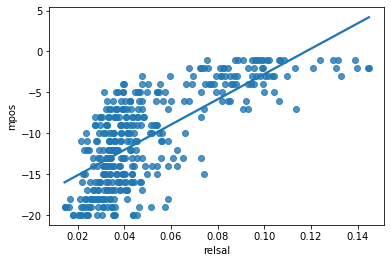

In [11]:
sns.regplot(x="relsal", y="mpos", data = EPL, ci=False)

One thing you might notice about the data is that there appears to be a certain amount of curvature, with many dots (each dot represents a single team in a single year) located around the lower values on the x axis, and a smaller number of clubs strung out with high values on the x and y axes. This is a common feature of many types of data. In our regression, we estimate a linear relationship. Hence, it is better if we can first linearize our data, which we can often achieve by taking logarithms. We do that next.

In [12]:
EPL['lnpos']= -np.log(EPL['Position'])

<AxesSubplot:xlabel='relsal', ylabel='lnpos'>

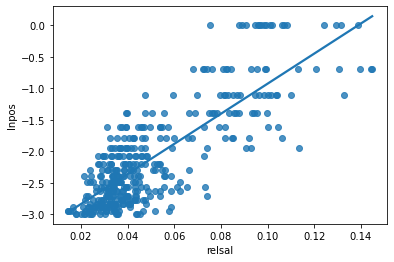

In [13]:
sns.regplot(x="relsal", y="lnpos", data = EPL, ci=False)

We now run the simple regression of league position on salaries:

In [14]:
possal1_lm = smf.ols(formula = 'lnpos ~ relsal ', data=EPL).fit()
print(possal1_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnpos   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     715.6
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           9.02e-89
Time:                        11:59:00   Log-Likelihood:                -243.89
No. Observations:                 375   AIC:                             491.8
Df Residuals:                     373   BIC:                             499.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3181      0.051    -64.725      0.0

As with the NBA data, the relsal variable is statistically significant. However, it is also noticeable that its impact is much larger, in that it accounts for much more of the variation in league position - the R-squared is 0.657, meaning that almost two thirds of the variation can be explained by salaries alone (recall the figure was 17% for the NBA).

Why is that relsal is so much more powerful in terms of explaining the variation in player salaries for the EPL than it was for the NBA? The answer lies in what was discussed at the beginning of this notebook - there are fewer restrictions on the operation of the market, there is much greater inequality between the teams, and this reveals itself in the fact that salaries are a much better explanatory variable for team performance.

We now consider other factors, to see if omitted variable bias might have caused us to under- or over- estimate the impact of player salaries. 

The first factor we consider is one that is specific to the promotion and relegation system. During the period in question, three teams were promoted to the EPL in each year (replacing three teams that had been relegated). Do promoted teams start with a disadvantage relative to other teams? We can test for this by adding a dummy variable which is equal to one if the team in question was promoted to the EPL in that season, and otherwise equals zero. We run the regression again with the promotion dummy variable included:

## Self Test

Try running the regression again using mpos instead of lnpos as the y variable. What differences do you see when comparing the two regressions?

In [15]:
possal2_lm = smf.ols(formula = 'lnpos ~ relsal + promoted_last_season', data=EPL).fit()
print(possal2_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnpos   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     356.8
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           3.03e-87
Time:                        12:01:17   Log-Likelihood:                -243.89
No. Observations:                 375   AIC:                             493.8
Df Residuals:                     372   BIC:                             505.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.3185 

The coefficient on promotion is statistically insignificant. This might come as a surprise - it might seem obvious that promoted teams are at a disadvantage, but there are other factors at play. If a promoted team spends money on players, then they appear to be in same position as everyone else. However, promoted teams may not have as much cash to spend, and hence they do experience a disadvantage, but that is channeled entirely through the effect of relsal. Promoted teams are often smaller than the established teams, but they often enjoy a boost in popularity from fans who are excited by the team's improved status. There can be positive and negative factors associated with promotion, and these can cancel each other out.

Note that the addition of the promotion variable hardly changed the estimated coefficient of relsal. 

Given that the promotion effect is statistically insignificant, we now drop it from the regression analysis.

We now consider, as we did with the NBA, the impact of lagged dependent variable- league position in the previous season. As before, we do this by first sorting the df by teams and by season, and then use .shift(1) to create the lag of league position.

In [16]:
EPL.sort_values(by=['Club','Season_ending'], ascending=True)
EPL

,Season_ending,Club,promoted_last_season,Position,Revenues,salaries,allsal,relsal,mpos,lnpos
0,1997,Arsenal,0,3,27158007,15279000,219599462,0,-3,-1
1,1997,Aston Villa,0,5,22079000,10070000,219599462,0,-5,-2
2,1997,Blackburn Rovers,0,13,14302220,14336629,219599462,0,-13,-3
3,1997,Chelsea,0,6,23729000,14873000,219599462,0,-6,-2
4,1997,Coventry City,0,17,12264825,8396261,219599462,0,-17,-3
...,...,...,...,...,...,...,...,...,...,...
375,2015,Sunderland,0,16,101087000,77106000,2031348184,0,-16,-3
376,2015,Swansea City,0,8,103928360,82540562,2031348184,0,-8,-2
377,2015,Tottenham Hotspur,0,5,196377000,100832000,2031348184,0,-5,-2
378,2015,West Bromwich Albion,0,13,96269000,69801000,2031348184,0,-13,-3


In [17]:
pd.set_option('display.max_rows', 400)
EPL

,Season_ending,Club,promoted_last_season,Position,Revenues,salaries,allsal,relsal,mpos,lnpos
0,1997,Arsenal,0,3,27158007,15279000,219599462,0,-3,-1
1,1997,Aston Villa,0,5,22079000,10070000,219599462,0,-5,-2
2,1997,Blackburn Rovers,0,13,14302220,14336629,219599462,0,-13,-3
3,1997,Chelsea,0,6,23729000,14873000,219599462,0,-6,-2
4,1997,Coventry City,0,17,12264825,8396261,219599462,0,-17,-3
5,1997,Derby County,1,12,10737571,6406557,219599462,0,-12,-2
6,1997,Everton,0,15,18881961,10933090,219599462,0,-15,-3
7,1997,Leeds United,0,11,22249000,12312000,219599462,0,-11,-2
8,1997,Leicester City,1,9,17320000,8914000,219599462,0,-9,-2
9,1997,Liverpool,0,4,39394000,14559000,219599462,0,-4,-1


In [18]:
EPL['lnpos_lag'] = EPL.groupby('Club')['lnpos'].shift(1)
EPL

,Season_ending,Club,promoted_last_season,Position,Revenues,salaries,allsal,relsal,mpos,lnpos,lnpos_lag
0,1997,Arsenal,0,3,27158007,15279000,219599462,0,-3,-1,NaN
1,1997,Aston Villa,0,5,22079000,10070000,219599462,0,-5,-2,NaN
2,1997,Blackburn Rovers,0,13,14302220,14336629,219599462,0,-13,-3,NaN
3,1997,Chelsea,0,6,23729000,14873000,219599462,0,-6,-2,NaN
4,1997,Coventry City,0,17,12264825,8396261,219599462,0,-17,-3,NaN
5,1997,Derby County,1,12,10737571,6406557,219599462,0,-12,-2,NaN
6,1997,Everton,0,15,18881961,10933090,219599462,0,-15,-3,NaN
7,1997,Leeds United,0,11,22249000,12312000,219599462,0,-11,-2,NaN
8,1997,Leicester City,1,9,17320000,8914000,219599462,0,-9,-2,NaN
9,1997,Liverpool,0,4,39394000,14559000,219599462,0,-4,-1,NaN


If you scroll through the df you will see that, as with the NBA data, we have missing values (NaN) for the first season (1997), since the values for the previous season are not in the data. But also you will see that there are missing values for some teams in other seasons. These are for clubs which were promoted in that season, and hence they had no lagged value for their EPL position.

This means we will lose some observations when we run the regressions. It's always worse to have fewer observations, but on the other hand it's always better to include potential omitted variables. There is a trade-off here between reducing the size of our dataset and including all relevant variables. Here the problem is not too serious, since we lose 42 observations and still have 333 in our dataset, whereas we expect that omitting the lagged dependent variable would lead to significant bias in the estimate of relsal.

In [19]:
possal3_lm = smf.ols(formula = 'lnpos ~lnpos_lag + relsal', data=EPL).fit()
print(possal3_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnpos   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     400.0
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           6.22e-89
Time:                        12:02:38   Log-Likelihood:                -192.18
No. Observations:                 333   AIC:                             390.4
Df Residuals:                     330   BIC:                             401.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0502      0.176    -11.633      0.0

As expected, the lagged dependent variable has a a large and statistically significant effect on league position. As far as our estimate of relsal is concerned, we can see that our estimate has fallen from 23.9 to 14.7, suggesting that the omission of the lagged dependent variable led to a significant upward bias in our estimate of relsal.

Finally, as we did with the NBA, we consider the possible effects of heterogeneity by adding fixed effects into our regression, recall that we do this simply by adding C(Club) to our regression formula:

In [20]:
possal4_lm = smf.ols(formula = "lnpos ~ lnpos_lag + relsal +C(Club)", data=EPL).fit()
print(possal4_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnpos   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     20.86
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           8.34e-65
Time:                        12:03:15   Log-Likelihood:                -168.86
No. Observations:                 333   AIC:                             421.7
Df Residuals:                     291   BIC:                             581.7
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Remember that our main interest is in the effect of relsal. Adding the fixed effects has reduced the value of the coefficient a little further - to 10.98 - again suggesting that our original specification suffered from omitted variable bias, which biased our estimate of relsal upwards.

Before asking what the value of the coefficient of relsal means for league position, we should stop to consider the fixed effects. As can be seen from the regression output, almost all are negative and statistically significant. The reason for this is that when estimating the fixed effects there must always be a reference group- so that the fixed effect measures performance relative to the reference group. By default Python uses the first name on the list as the reference group, and since our clubs are listed alphabetically, the reference group is Arsenal. Now, over the period 1997-2015 Arsenal was one of the most consistently successful teams, which explains why most of the coefficients are negative. Most teams were performing worse than Arsenal, even after taking account of wage spending via relsal. 

In this case, it might make more sense to evaluate the fixed effects relative to a mid-table team. We can choose the reference group, but first let's list the average league performance of the teams, to see which club would be a good candidate for the reference group. We use .groupby() to calculate average leagues position by club:

In [21]:
Avpos = EPL.groupby(['Club'])['Position'].mean()
Avpos

Club
Arsenal                    3
Aston Villa               10
Barnsley                  19
Birmingham City           14
Blackburn Rovers          12
Blackpool                 19
Bolton Wanderers          13
Bradford City             18
Burnley                   18
Cardiff City              20
Charlton Athletic         13
Chelsea                    3
Coventry City             15
Crystal Palace            15
Derby County              14
Everton                   10
Fulham                    12
Hull City                 18
Ipswich Town              12
Leeds United               8
Leicester City            13
Liverpool                  4
Manchester City            8
Manchester United          2
Middlesbrough             13
Newcastle United          10
Norwich City              15
Nottingham Forest         20
Portsmouth                14
Queens Park Rangers       19
Reading                   15
Sheffield United          18
Sheffield Wednesday       14
Southampton               12
Stoke Cit

"Mid-table" means an average league position of 10 or 11. There are a few we could choose from, but one of the most consistent over the period was Everton, so we use them.

To specify the reference group we expand the C() statement to define the "treatment" group reference. Hence we write C(Club, Treatment('Everton')):

In [22]:
possal5_lm = smf.ols(formula = "lnpos ~ lnpos_lag + relsal +C(Club, Treatment('Everton'))", data=EPL).fit()
print(possal5_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnpos   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     20.86
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           8.34e-65
Time:                        12:06:07   Log-Likelihood:                -168.86
No. Observations:                 333   AIC:                             421.7
Df Residuals:                     291   BIC:                             581.7
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

We now see that only four clubs have statistically significant coefficients. Two of these are Manchester United and Arsenal, the two dominant clubs over the period. This implies that these clubs, which spent more money than the others on players, still managed to extract better than average performance from these players. This fact is likely related to the two iconic managers of these clubs, Sir Alex Ferguson and Arsene Wenger.

Notice that changing the reference group does not change the coefficient on relsal or on the lagged dependent variable. The R-squared of the regression, or any other diagnostic statistic. The only thing that changes are the coefficients of the fixed effects themselves, and also the coefficient of the constant. 

## Self Test

Calculate the fixed effects using Sunderland as the reference team. What changes do you see in the estimates?

Finally, we consider how changes in relsal affect league positions, given our estimated coefficient of just under 11. Ignoring the fixed effects and the lagged dependent variable, minus the log of league position can be expressed as a function of the constant plus the relsal coefficient times the value of relsal, i.e. -lnpos = -2.1 + 11 relsal. Because we have expressed league position as a logarithm, the impact on league position will differ for different values of relsal. From the charts above we can see that relsal varies roughly between 0.02 (2%) and 0.14 (14%). 

Let's consider three values of relsal: .02, .07 and .14. What league positions are implied by these values? To convert -lnpos back into position we have to multiply by -1 and then take the exponent. To take an exponent using numpy you just type np.exp() with the expression in parentheses. If we do that to the right hand side of the equation then we have our answer.

In [23]:
print(np.exp(2.1- 11*.02))
print(np.exp(2.1- 11*.08))
print(np.exp(2.1- 11*.14))


6.553504862191149
3.387187733621335
1.7506725002961012


It is not surprising to see that the highest spending level implies a very high league position - somewhere between first (1) and second (2). It is more suprising to see that a level of spending somewhere around the mean (0.08) implies a position between 3rd and 4th, while even lowest spending (.02) implies a league position between 6th and 7th. The explanation for this lies with the role of the lagged dependent variable. This tends to emphasize the role of past performance in contributing to current performance. Teams that are able to spend consistently can more easily achieve a high league position than teams which attempt to do so by a short term infusion of spending.

## Self Test

Calculate the expected position of (a) Arsenal and (b) West Ham United, using the same relsal values as above (i.e. when relsal is .02, .08 and .14) but now including the fixed effects for the two clubs. 

# Conclusion

While we have repeated the analysis that we conducted for the NBA almost exactly, our results have been quite different, reflecting the different organizational structure of the soccer in England (and in other soccer leagues outside North America). The main result of our analysis is that salary spending varies much more than it does in the NBA, and has a much larger impact on outcomes, even after we allow for possible omitted variables and heterogeneity. Next week we will look at Major League Baseball (MLB).